In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/liveness_detection

In [ ]:
pwd

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array

2024-11-30 13:44:23.833909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732949064.620971     916 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732949064.656993     916 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 13:44:24.963136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  1


In [ ]:
print("TensorFlow version:", tf.__version__)

In [ ]:
# Direktori dataset
DATASET_DIR = "../datasets/datasets/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25

In [3]:
TRAIN_SET = os.path.join(DATASET_DIR, "train_blink_set")
TEST_SET = os.path.join(DATASET_DIR, "test_blink_set")

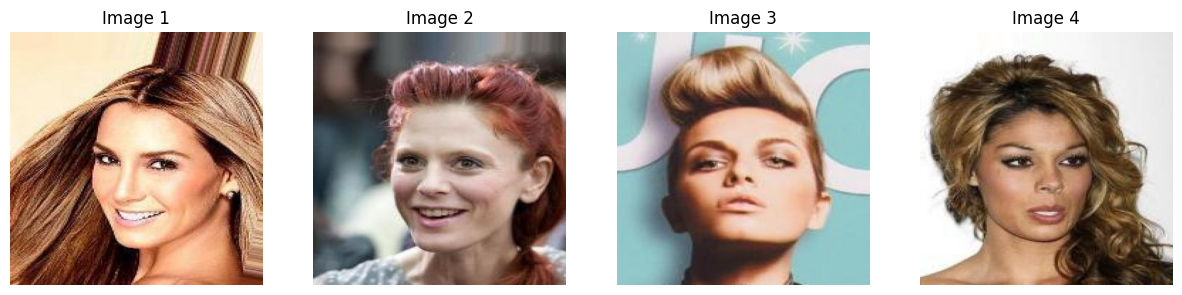

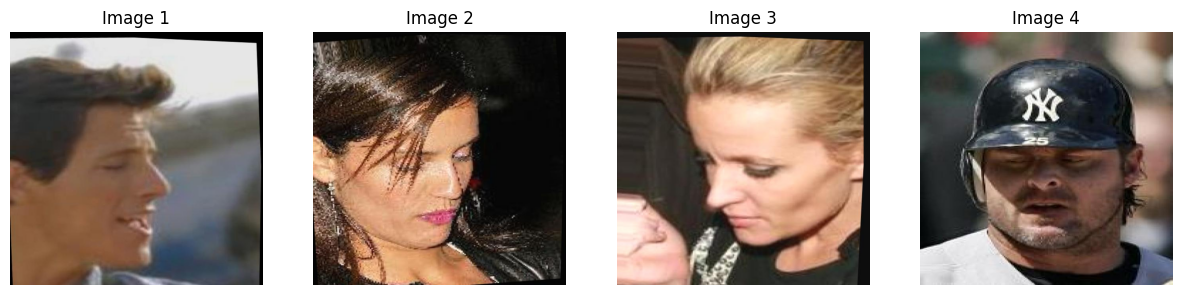

In [4]:
# Fungsi untuk menampilkan gambar
def show_images(directory, num_images=5):
  """Menampilkan beberapa gambar dari direktori yang diberikan.

  Args:
    directory: Path ke direktori yang berisi gambar.
    num_images: Jumlah gambar yang akan ditampilkan.
  """
  image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
  fig, axes = plt.subplots(1, min(num_images, len(image_files)), figsize=(15, 5))
  for i, ax in enumerate(axes):
      if i < len(image_files):
          image_path = os.path.join(directory, image_files[i])
          img = mpimg.imread(image_path)
          ax.imshow(img)
          ax.axis('off')
          ax.set_title(f"Image {i+1}")
  plt.show()

# Menampilkan 4 gambar dari direktori "real" dalam dataset
opened_eyes = os.path.join(TRAIN_SET, "opened_eyes")
show_images(opened_eyes, num_images=4)

# Menampilkan 4 gambar dari direktori "fake" dalam dataset
closed_eyes = os.path.join(TRAIN_SET, "closed_eyes")
show_images(closed_eyes, num_images=4)


In [5]:
# Pilih satu gambar secara acak dari direktori opened eyes dan closed eyes
closed_eyes = os.path.join(TRAIN_SET, 'closed_eyes')
opened_eyes = os.path.join(TRAIN_SET, 'opened_eyes')

attack_images = [os.path.join(closed_eyes, f) for f in os.listdir(closed_eyes) if os.path.isfile(os.path.join(closed_eyes, f))]
liveness_images = [os.path.join(opened_eyes, f) for f in os.listdir(opened_eyes) if os.path.isfile(os.path.join(opened_eyes, f))]

random_attack_image_path = random.choice(attack_images)
random_liveness_image_path = random.choice(liveness_images)

image_paths = [random_attack_image_path, random_liveness_image_path]

In [6]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fungsi untuk melakukan cropping pada gambar
def crop_center(image, cropx, cropy):
    y, x, _ = image.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return image[starty:starty+cropy, startx:startx+cropx]

# Fungsi preprocessing yang menggabungkan cropping dan preprocessing MobileNetV3
def preprocess_and_crop(image):
    image = img_to_array(image)
    image = crop_center(image, 224, 224)
    image = preprocess_input(image)
    return image

In [19]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_and_crop,
    validation_split=0.2,
    brightness_range=[0.7, 1.3],
    # horizontal_flip=True,
    # vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    fill_mode='nearest',
    channel_shift_range=0.2
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_and_crop)

train_generator = train_datagen.flow_from_directory(
    TRAIN_SET,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    TEST_SET,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 4691 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


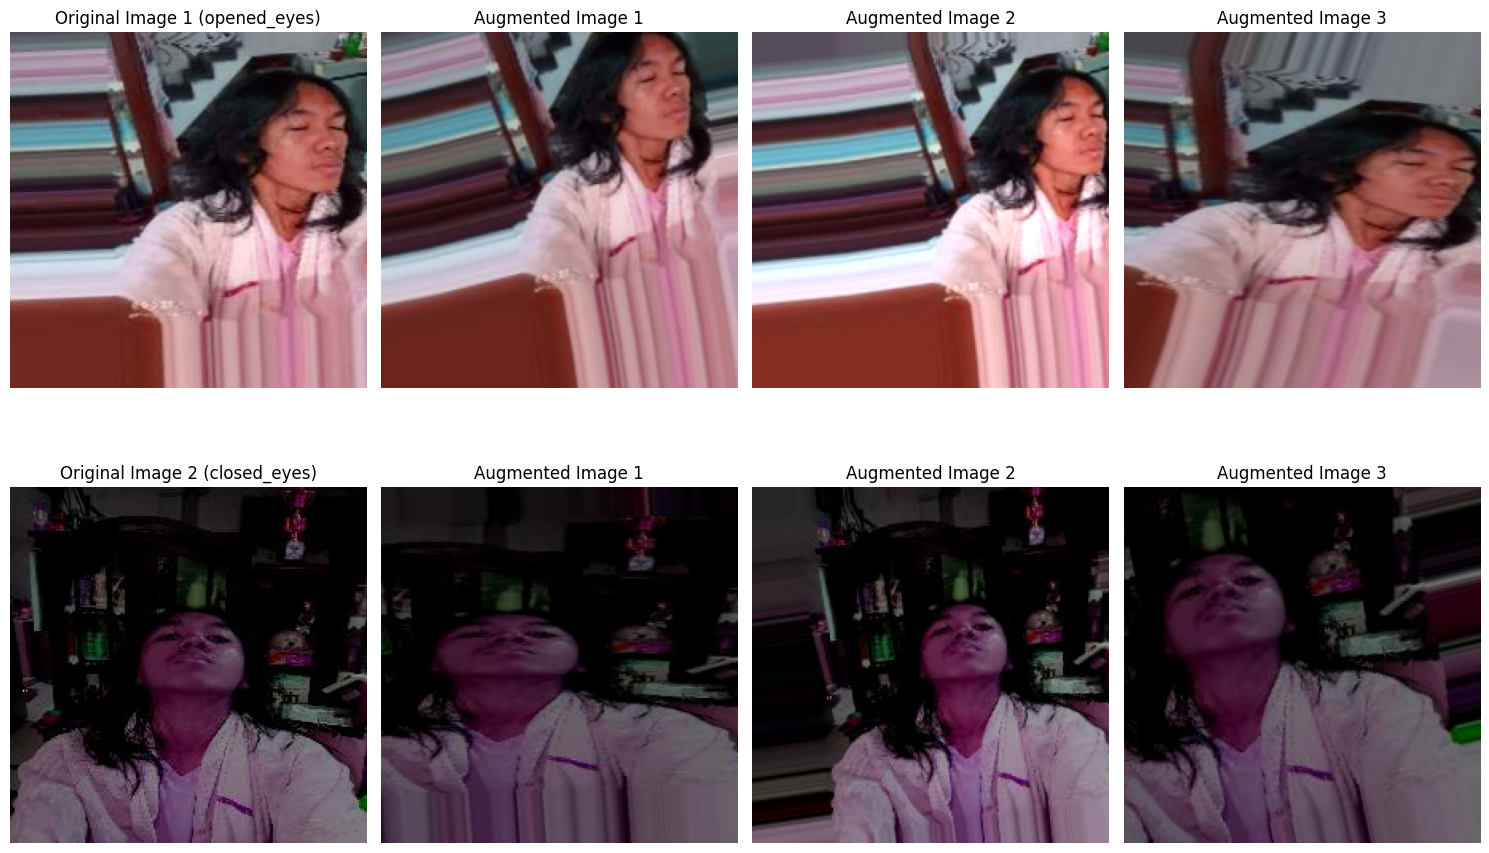

In [20]:
# Load dan augmentasi gambar
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
for i, img_path in enumerate(image_paths):
  img = load_img(img_path)
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape)

  # Buat ImageDataGenerator untuk augmentasi
  datagen = train_datagen

  # Generate gambar augmentasi
  augmented_images = [next(datagen.flow(x, batch_size=1))[0] for _ in range(3)]

  # Tampilkan gambar original dan augmentasi
  axes[i, 0].imshow(img)
  axes[i, 0].set_title(f"Original Image {i+1} ({'opened_eyes' if i == 0 else 'closed_eyes'})")
  axes[i, 0].axis('off')

  for j, augmented_image in enumerate(augmented_images):
    axes[i, j+1].imshow(augmented_image.astype('uint8'))
    axes[i, j+1].set_title(f"Augmented Image {j+1}")
    axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

In [21]:
# Model Transfer Learning dengan EfficientNetB_

# from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(x)
x = MaxPooling2D(2, 2)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Fine-tuning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None and val_acc is not None:
            if acc >= 0.99 and val_acc >= 0.98999:
                print("\nReached target accuracy, stopping training...")
                self.model.stop_training = True

In [22]:
# Callback
checkpoint_path = "../model_download/blink/model_blink_4.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
                save_freq="epoch",
            )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# custom_callback = CustomCallback()

In [23]:
# Training
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint,
               early_stopping,
              #  custom_callback,
               lr_scheduler]
)

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - Precision: 0.5434 - Recall: 0.5245 - accuracy: 0.5475 - loss: 14.8835
Epoch 1: val_accuracy improved from -inf to 0.59483, saving model to ../model_download/blink/model_blink_4.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 504ms/step - Precision: 0.5438 - Recall: 0.5250 - accuracy: 0.5478 - loss: 14.8696 - val_Precision: 0.6038 - val_Recall: 0.5517 - val_accuracy: 0.5948 - val_loss: 9.1973 - learning_rate: 1.0000e-04
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - Precision: 0.6698 - Recall: 0.6700 - accuracy: 0.6664 - loss: 7.8337
Epoch 2: val_accuracy did not improve from 0.59483
147/147 ━━━━━━━━━━━━━━━━━━━━ 62s 418ms/step - Precision: 0.6698 - Recall: 0.6701 - accuracy: 0.6664 - loss: 7.8261 - val_Precision: 0.6923 - val_Recall: 0.1552 - val_accuracy: 0.5431 - val_loss: 4.8871 - learning_rate: 1.0000e-04
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - Precision: 0.7004 - Recall: 0.6988 - accuracy: 0.7007 - loss: 4.1288

In [ ]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# # Fine-tuning
# for layer in base_model.layers:
#     layer.trainable = True

# model.compile(optimizer=Adam(learning_rate=0.00001),
#               loss='binary_crossentropy',
#               metrics=['accuracy', 'Precision', 'Recall'])

# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# history = model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=EPOCHS,
#     callbacks=[checkpoint,
#                early_stopping,
#               #  custom_callback,
#                lr_scheduler]
# )

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1732009862.025533   53378 service.cc:148] XLA service 0x7fecf00022b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732009862.025592   53378 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-19 16:51:04.406626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732009872.811938   53378 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1732009911.576029   53378 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732009911.880596   53378 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732009912.167

 25/104 ━━━━━━━━━━━━━━━━━━━━ 40s 508ms/step - Precision: 0.3974 - Recall: 0.0327 - accuracy: 0.5320 - loss: 25.4247

2024-11-19 16:53:29.895401: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51420', 4 bytes spill stores, 4 bytes spill loads

2024-11-19 16:53:36.685770: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[8,6,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,144,1,1]{3,2,1,0}, f32[6,144,1,1]{3,2,1,0}, f32[6]{0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-19 16:53:36.690388: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.151757234s
Trying algorithm eng13{} for conv (f32[8,6,1,1]{3,2,1,0}, u8[0]{0}

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.5254 - Recall: 0.0854 - accuracy: 0.5432 - loss: 25.1461

2024-11-19 16:55:53.552151: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4864', 4 bytes spill stores, 4 bytes spill loads

2024-11-19 16:55:59.872020: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[13,240,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,240,56,56]{3,2,1,0}, f32[240,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=240, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-19 16:56:00.306816: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.43490462s
Trying algorithm eng3{k11=0} for conv (f32[1


Epoch 1: val_accuracy improved from -inf to 0.68765, saving model to ../datasets/pictures/model_download/model_blink.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - Precision: 0.5271 - Recall: 0.0863 - accuracy: 0.5435 - loss: 25.1425 - val_Precision: 0.9211 - val_Recall: 0.3627 - val_accuracy: 0.6877 - val_loss: 24.0125 - learning_rate: 1.0000e-05
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - Precision: 0.8262 - Recall: 0.4741 - accuracy: 0.7011 - loss: 23.6543
Epoch 2: val_accuracy improved from 0.68765 to 0.84746, saving model to ../datasets/pictures/model_download/model_blink.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 508ms/step - Precision: 0.8265 - Recall: 0.4751 - accuracy: 0.7017 - loss: 23.6507 - val_Precision: 0.8693 - val_Recall: 0.7927 - val_accuracy: 0.8475 - val_loss: 22.4954 - learning_rate: 1.0000e-05
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - Precision: 0.9106 - Recall: 0.8158 - accuracy: 0.8751 - loss: 22.1177
Epoch 3: val_accuracy improved from 

In [24]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 924ms/step - Precision: 0.8001 - Recall: 0.7976 - accuracy: 0.8161 - loss: 0.7282
Loss: 0.731518030166626, Accuracy: 0.818965494632721, Precision: 0.8363636136054993, Recall: 0.7931034564971924


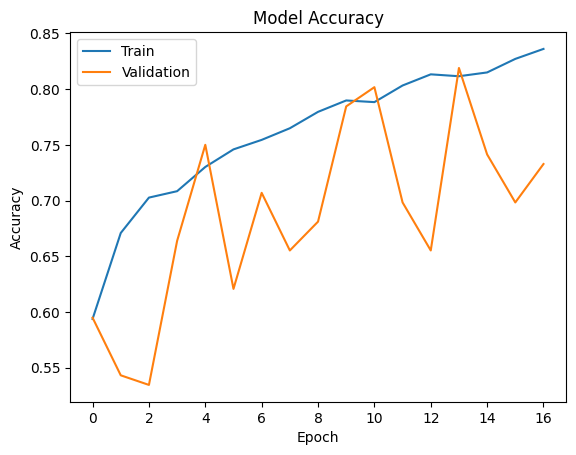

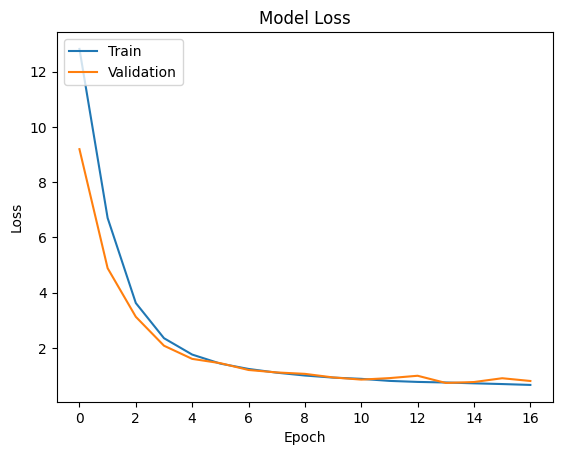

In [25]:
# Plot accuracy dan val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss dan val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('../datasets/pictures/model_download/model_blink.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
  img = load_img(image_path, target_size=IMG_SIZE)
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  # img_array /= 255.  # Normalize the image if your model expects normalized input
  return img_array

# Example usage:
# test_image_path = "../datasets/test/test/closed eyes.jpeg" # Replace with the path to your test image
test_image_path1 = "../datasets/test/test/OIP (2).jpeg"
test_image_path2 = "../datasets/test/test/closed eyes.jpeg"

preprocessed_image1 = preprocess_image(test_image_path1)
prediction1 = model.predict(preprocessed_image1)
preprocessed_image2 = preprocess_image(test_image_path2)
prediction2 = model.predict(preprocessed_image2)

if prediction[0][0] > 0.5:
  print("Prediction: opened")
else:
  print("Prediction: closed")

# You can also get the confidence score
print(f"Confidence score: {prediction[0][0]}")
print(f"Confidence score: {prediction[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: closed
Confidence score: 0.015078532509505749
Confidence score: 0.015078532509505749


: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediction: opened eyes
Confidence score: 0.4501


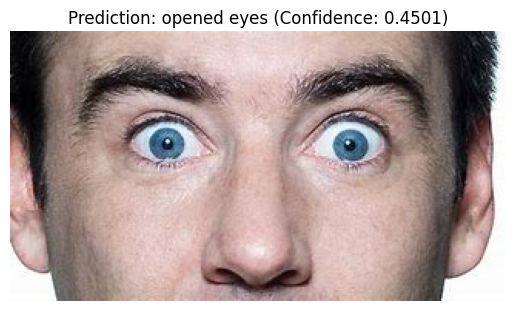

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: opened eyes
Confidence score: 0.4517


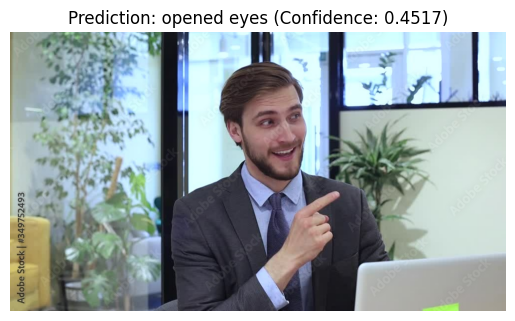

In [28]:
# Load the saved model
model = tf.keras.models.load_model('../model_download/blink/model_blink_4.keras')

# Fungsi untuk memproses gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Tambahkan dimensi batch
    img_array = img_array / 255.0  # Normalisasi nilai piksel
    return img_array

# Fungsi untuk memprediksi gambar
def predict_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)

    if prediction[0][0] > 0.5:
        label = "closed eyes"
    else:
        label = "opened eyes"

    confidence = prediction[0][0] if label == "opened eyes" else 1 - prediction[0][0]

    print(f"Prediction: {label}")
    print(f"Confidence score: {confidence:.4f}")
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Prediction: {label} (Confidence: {confidence:.4f})")
    plt.axis('off')
    plt.show()

# Example usage:
test_image_path1 = "../datasets/test/test/opened eyes.jpeg"
test_image_path2 = "../datasets/test/test/left2.jpg"


predict_image(test_image_path1)
predict_image(test_image_path2)


In [6]:
# Predict function
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array /= 255.0  # Rescale

    prediction = model.predict(img_array)
    return 'Open Eyes' if prediction[0] > 0.5 else 'Closed Eyes'

# Function to detect blink
def detect_blink(image_paths):
    status = [predict_image(image_path) for image_path in image_paths]
    blink_detected = False
    for i in range(1, len(status) - 1):
        if status[i-1] == 'Open Eyes' and status[i] == 'Closed Eyes' and status[i+1] == 'Open Eyes':
            blink_detected = True
            break
    return blink_detected

# Example usage
image_sequence = [
    '../datasets/test/test/OIP (2).jpeg',
    '../datasets/test/test/OIP.jpeg',
    '../datasets/test/test/OIP (1).jpeg'
]
print(detect_blink(image_sequence))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
False


In [29]:
# COnvert to tflite

model = tf.keras.models.load_model('../model_download/blink/model_blink_4.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert()

tflite_model_path = '../model_download/blink/model_blink_4.tflite' 
with open(tflite_model_path, 'wb') as f: 
    f.write(tflite_model) 
    
print(f"Model converted and saved to {tflite_model_path}")

INFO:tensorflow:Assets written to: /tmp/tmpu6xv0efi/assets


INFO:tensorflow:Assets written to: /tmp/tmpu6xv0efi/assets


Saved artifact at '/tmp/tmpu6xv0efi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140145188479296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148207046144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148207053712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148207055296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148207052656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148207044912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140143715167824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140143715167120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140143715163776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140143715164480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401437151618

W0000 00:00:1732959029.124333     916 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732959029.126580     916 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-30 16:30:29.140979: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpu6xv0efi
2024-11-30 16:30:29.147558: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-30 16:30:29.147589: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpu6xv0efi
I0000 00:00:1732959029.219690     916 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-11-30 16:30:29.236662: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-30 16:30:29.850938: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpu6xv0efi
2024-11-30 16:30:29.967390: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

Model converted and saved to ../model_download/blink/model_blink_4.tflite


In [31]:
# Memuat model Keras
model = tf.keras.models.load_model('../model_download/blink/model_blink_4.keras')

# Mengonversi model ke TFLite dengan kuantisasi rentang dinamis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

# Menyimpan model TFLite yang telah dikuantisasi ke file
tflite_model_quant_path = '../model_download/blink/model_blink_4_quant.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print("Model TFLite dengan kuantisasi rentang dinamis telah disimpan.")

INFO:tensorflow:Assets written to: /tmp/tmp7a2f8xgx/assets


INFO:tensorflow:Assets written to: /tmp/tmp7a2f8xgx/assets


Saved artifact at '/tmp/tmp7a2f8xgx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140148062201712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148062488880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148062489408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148062204704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148062500320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148062497328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148062294384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148062295264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148062303008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148062298784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401480623023

W0000 00:00:1732959731.271069     916 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732959731.271134     916 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-30 16:42:11.271339: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7a2f8xgx
2024-11-30 16:42:11.277284: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-30 16:42:11.277320: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp7a2f8xgx
2024-11-30 16:42:11.358487: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-30 16:42:11.874246: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp7a2f8xgx
2024-11-30 16:42:11.994138: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 722804 microseconds.
